## ISYE 6402, Module 2 - Emergency Department Care Example

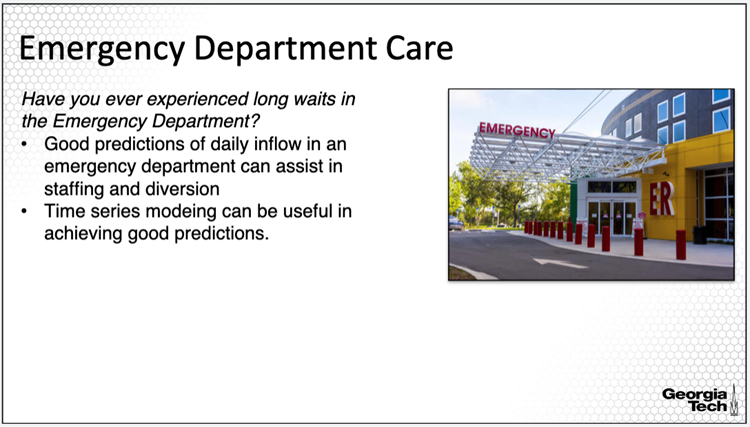

### Case Study Overview

A number of factors can influence daily ED visits; the patient’s visits forecasting model should include those factors. Previous studies have shown that ED visits present cyclical variations according to calendar variables such as day of the week, time of the year, and the occurrence of public holidays. The objective of this analysis is to develop models for identifying temporal patterns, and for predicting the volume of patients in an emergency department.
The data consist of daily number of patients seeking ED care in a hospital in Georgia, in the United States. The ED volume was observed over a period of more than five years from 2010 until about mid 2015. In this study we'll consider temporal factors, although other factors can be used, for example external factors such as temperature, rainfall, major holidays, school season among others. 

### Model Trend and Seasonality

In the previous module, I illustrated how to estimate the trend and seasonality for this particular data example. Note that we applied the modeling of the time series on the transformed time series since the observations in the time series are counts, and thus with a Poisson distribution, potentially indicating non constant variance over time. 

The model I selected here to use for removing the trend and seasonality is the model using the non-parametric trend estimation using spline smoothing, along with modelling monthly, and weekly seasonality. Specifically, I'm using the gam() R command available in the mgcv library to fit the trend and seasonality. For this, I defined the vector of equally spaced time points along with qualitative variables specifying the month, and day of the week for each observation to be all integrated into the estimation of the trend and seasonality, simultaneously using the gam function. 

Last, we take the difference between the transformed ED volume counts, and the estimated trend and seasonality to obtain the residual process to be further analyzed using the ARMA modeling. Note that here, we estimate the trend and seasonality in order to reduce the time series to a stationary process. We want to subtract/eliminate the trend and seasonality, and we'll analyze the residual process using the ARMA modeling. Let's take a closer look at the ACF and PACF plots to assess stationarity

In [1]:
############# DATA EXPLORATION AND PROCESSING ##########################
edvoldata = read.csv("EGDailyVolumeNew-1.csv",header=T)
head(edvoldata, 3)

## Process Dates 
year = edvoldata$Year
month = edvoldata$Month
day = edvoldata$Day
datemat = cbind(as.character(day),as.character(month),as.character(year))

head(datemat, 3)

,Year,Month,Day,Volume
,<int>,<int>,<int>,<int>
1,2010,1,1,135
2,2010,1,2,163
3,2010,1,3,139


1,1,2010
2,1,2010
3,1,2010


In [2]:
paste.dates = function(date){
    day = date[1]; month=date[2]; year = date[3]
    return(paste(day,month,year,sep="/"))
 }
dates = apply(datemat,1,paste.dates)
dates = as.Date(dates, format="%d/%m/%Y")
edvoldata = cbind(dates,edvoldata)
attach(edvoldata)

head(edvoldata, 3)

The following object is masked _by_ .GlobalEnv:

    dates




,dates,Year,Month,Day,Volume
,<date>,<int>,<int>,<int>,<int>
1,2010-01-01,2010,1,1,135
2,2010-01-02,2010,1,2,163
3,2010-01-03,2010,1,3,139


In [3]:
Volume.tr = sqrt(Volume+3/8)

## Model Trend + Monthly Seasonality
library(mgcv)
time.pts = c(1:length(Volume))
time.pts = c(time.pts - min(time.pts))/max(time.pts)

month = as.factor(format(dates,"%b"))
week = as.factor(weekdays(dates))

gam.fit.seastr = gam(Volume.tr~s(time.pts)+month+week)
vol.fit.gam.seastr = fitted(gam.fit.seastr)
resid.process = Volume.tr-vol.fit.gam.seastr

Loading required package: nlme

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.



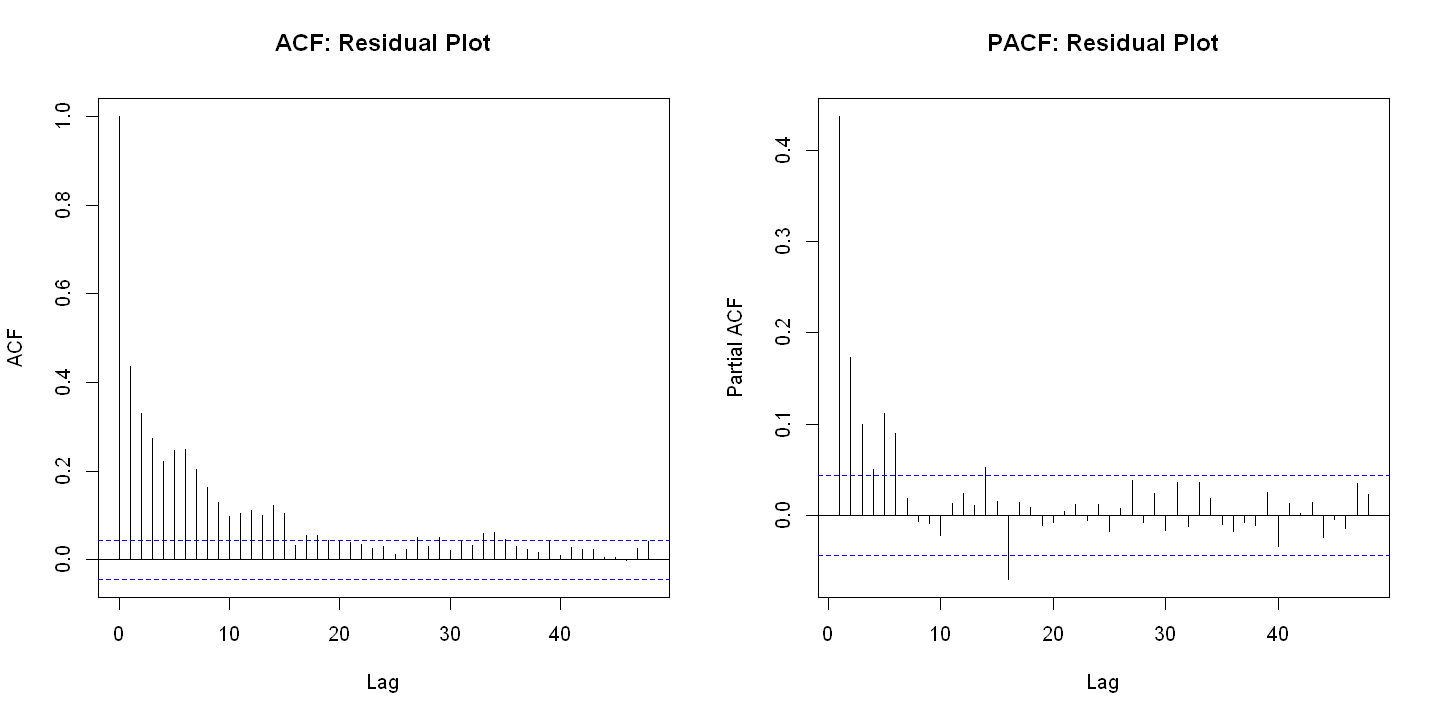

In [4]:
par(mfrow=c(1,2))
options(repr.plot.width=12, repr.plot.height=6)

################################################################
acf(resid.process,lag.max=12*4,main="ACF: Residual Plot")
pacf(resid.process,lag.max=12*4,main="PACF: Residual Plot")
###############################################################

The ACF is displayed on the upper plot, and PACF is displayed on the lower plot. For both, we see that a relatively small number of lags have a large number of ACF and PACF values, indicating that the trend has been removed. For evaluating the performance of the model after removing the seasonality, we need to plot the sample ACF for a larger number of lags to capture two or more seasonality periods. The ACF and PACF are thus plotted over more than 40 lags.

### Fitting an AR process

Next we'll fit an AR model only. 

- The R function is AR with an **input consisting of the time series, the residual process** for this example, and the maximum order for which to fit the AR model. Here the maximum order is set to 20. 
- In order to display the output for this model fit, you can use the summary command to get the order selected for the best fit according to AIC, the value is mod$order, and it is equal to six for this model. 
- I also plotted the AIC values, but on the log scale, to better see where the minimum of AIC is reached. 

[1] 6



Call:
ar(x = resid.process, order.max = 20)

Coefficients:
     1       2       3       4       5       6  
0.3233  0.1198  0.0613  0.0020  0.0818  0.0891  

Order selected 6  sigma^2 estimated as  0.4694

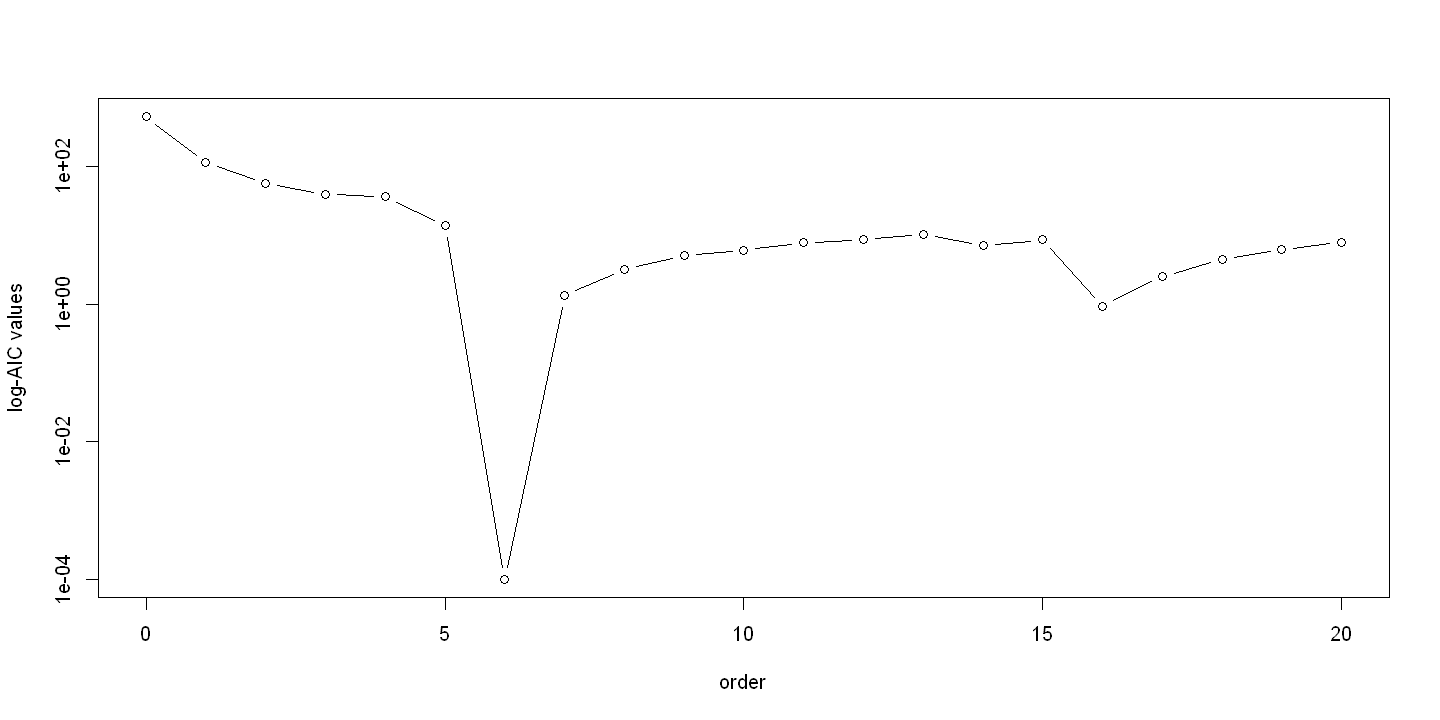

In [5]:
###### Fit an AR(p) process for for p<= order.max ####
mod = ar(resid.process,order.max=20)
# What is the selected order?
print(mod$order)

# find the list of arguments provided by AR fit
#summary(mod)
mod

# plot aic values
# On non-log scale it is difficult to detect the minimum.
plot(c(0:20),mod$aic+.0001, type="b",log="y",xlab="order",ylab="log-AIC values")

The AIC plot is here. Again, the selected order is six, as also shown by this graph. This AIC value is minimum at this order

### Fitted AR process: Properties

**Let's consider the property of stationarity, and whether the fitted model is a causal process.**

- For that, we need to extract the roots of the AR polynomial, and check whether they are not on the unit circle, indicating stationarity, and whether the roots are all outside of the unit circle indicating a causal process.
- **To get the roots, we can use the R command polyroot along with the AR coefficients in the reversed order since polyroot begins with the coefficients of higher order.**
- We also need to add the coefficient one for the constant. 
- Using the plot and lines commands provided on the slide, we can point where the points of the roots are on the xy graph, along with the line of the unit root circle for comparison.

[1]  0.763280+1.245970i -0.893764+1.314184i -0.893764-1.314184i
[4]  1.150875+0.000000i  0.763280-1.245970i -1.808621+0.000000i

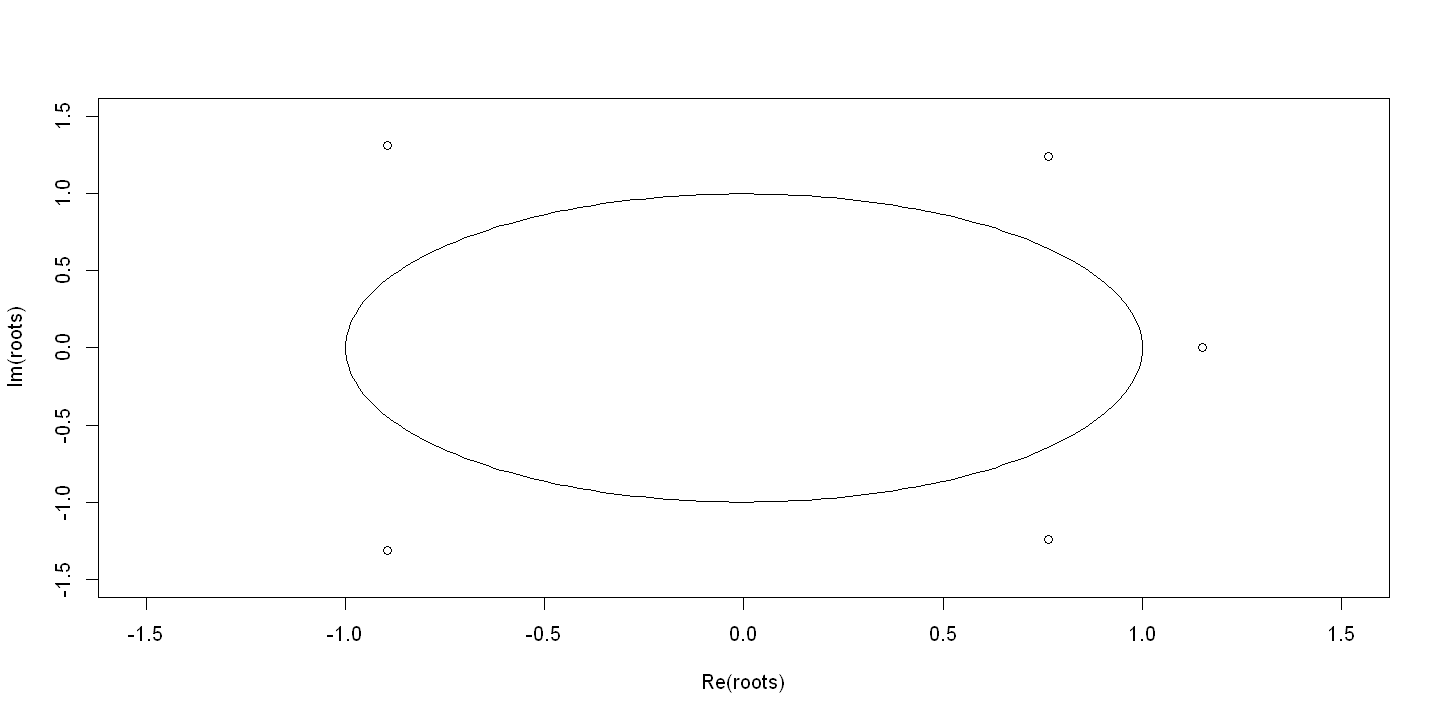

In [6]:
# Are the roots of fitted AR within the unit circle?
# extract roots from the model output
roots = polyroot(c(1,(-mod$ar)))
roots

# adjust the x and y -axis limits to include the full circle
plot(roots,xlim=c(-1.5,1.5),ylim=c(-1.5,1.5))
# draw a unit root circle
lines(complex(arg = seq(0,2*pi,len=300)))

**From the resulting plot, all the roots of the AR polynomial are not on the unit circle, thus the fitted AR process is stationary.**

**Moreover, all the roots are outside the unit circle, thus the process is causal**

### Fitted AR process: Residual Analysis

Further we can evaluate the residuals for stationarity, and other properties. For this, we extract the residuals from the fitted model, and then plot the residuals, the acf, and the pacf of the model residuals, and the quantile-quantile normality plot.

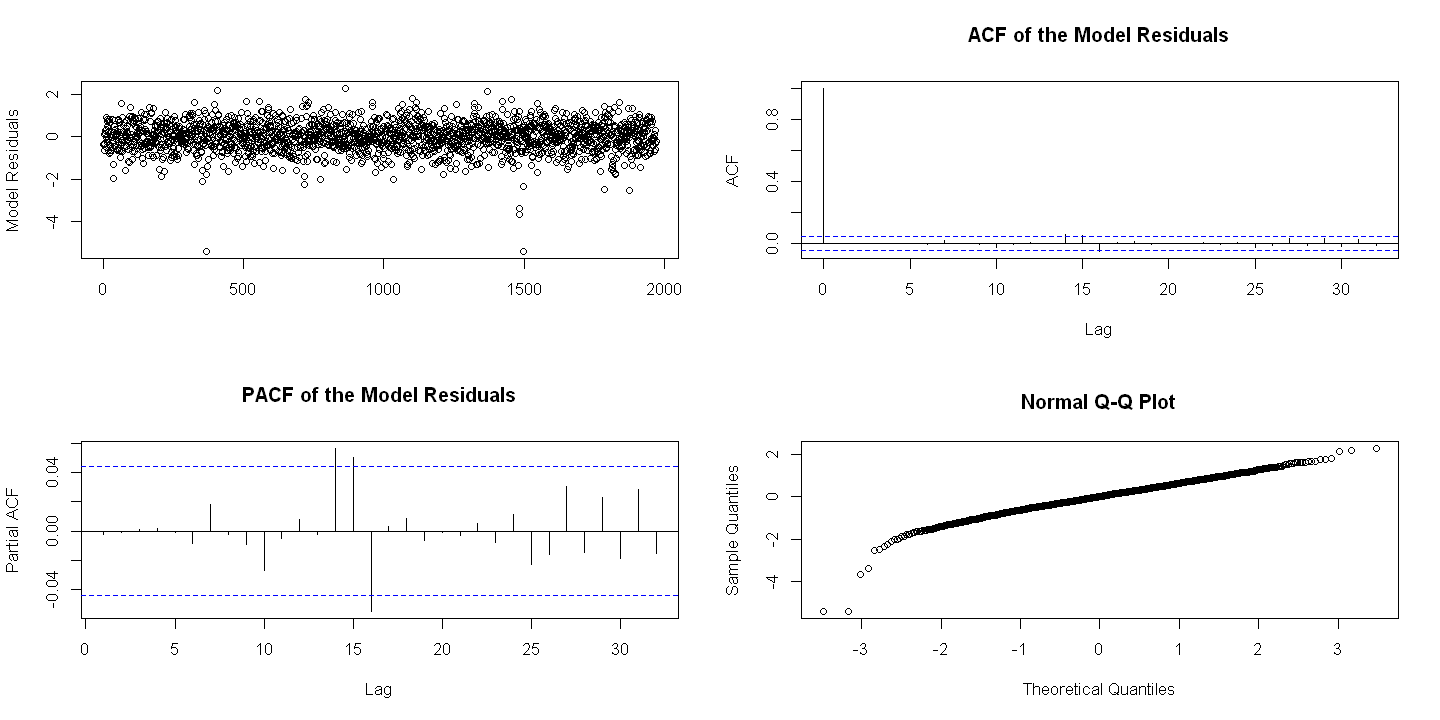

In [7]:
# residuals analysis
resids = mod$resid[(mod$order+1): length(mod$resid)]

par(mfrow=c(2,2))
plot(resids,xlab="",ylab="Model Residuals")
acf(resids,main='ACF of the Model Residuals')
pacf(resids,main='PACF of the Model Residuals')
qqnorm(resids)

The plots are on the slide. 
- The residual plot shown in the first figure does not show a pattern in the variability over time. 
- The ACF plot has only the first lag equal to one, where all other values of the lags are small within the confidence band. 
- The same for the sample PACF; most values are within the confidence band, with a few exceptions for which the sample partial autocorrelation is small close to the confidence bands. 
- The Q-Q Norm Plot shows a tail on the left but overall seems approximately normal.

### Fit an ARMA Model

Finally, we’ll fit an ARMA model, not only an AR model. 

- The R command for fitting an ARMA model is arima(), where we specify the time series, in this case the **residual time series, after removing the trend and seasonality.**
- We also need to specify the orders for the AR, and MA components of the model.
- For this fit, I'm using order 6 for AR, as specified by the best AR model fitted previously, and order 1 for the MA part.
- Last, we can specify the estimation method. If we specify ML, this means that we fit using maximum likelihood assuming normality.

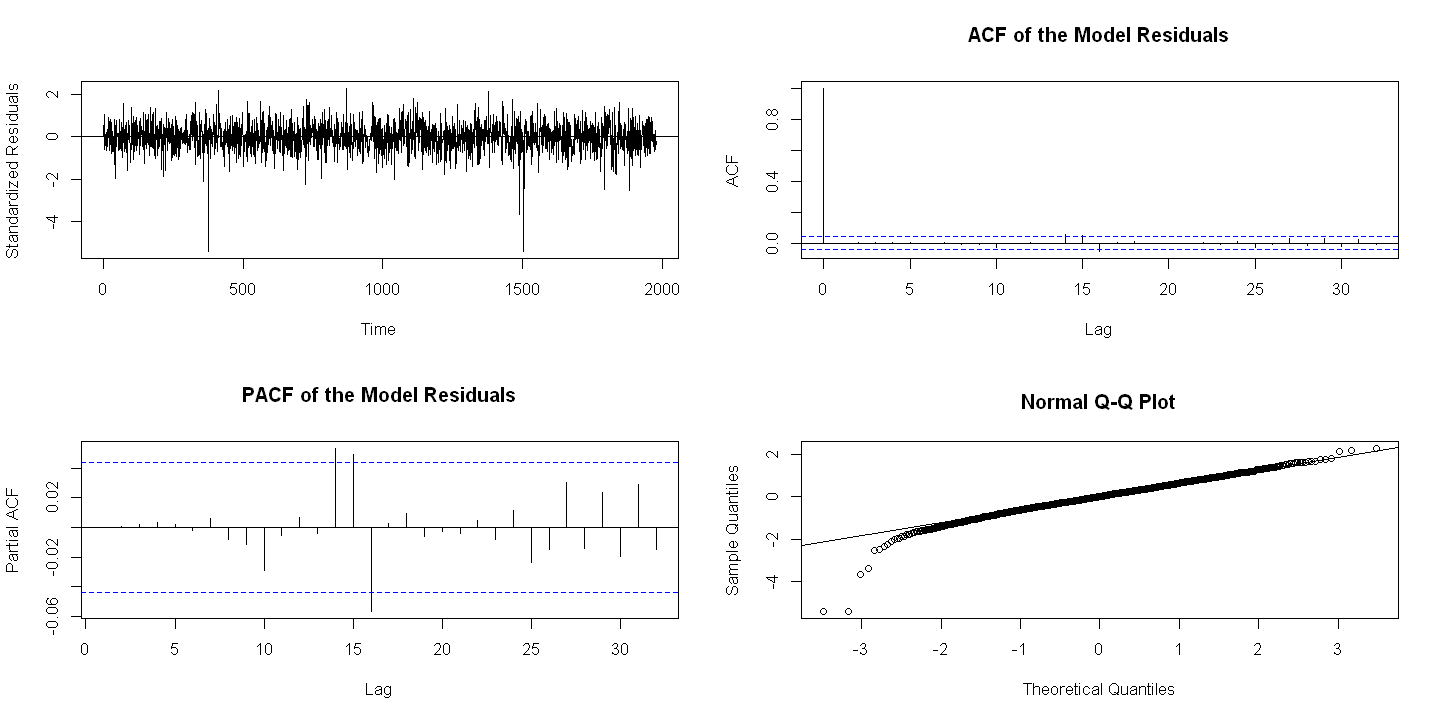

In [8]:
###### Fit an ARMA(p,q) for some values of p and q #####
modarma = arima(resid.process, order = c(6,0,1),method = "ML")

par (mfrow=c(2,2))
plot(resid(modarma), ylab='Standardized Residuals')
abline(h=0)
acf(as.vector(resid(modarma)),main= 'ACF of the Model Residuals')
pacf(as.vector(resid(modarma)),main='PACF of the Model Residuals')
qqnorm(resid(modarma))
qqline(resid(modarma))

Last, let's look at the residual plots of this fitted model. 
- The residual plot does not show to have a pattern. The variance of the residuals is also constant. 
- The ACF plot has only the first lag equal to one where all others are small within the confidence bands of the sample ACF. 
- The same for the sample PACF, the values are within the confidence band. 
- The Q-Q norm plot shows a tail on the left. 

These are similar observations from fitting the AR model alone. And it's not surprising since we only added, an MA(1) part, to the AR(6) of the model.

### ARMA Model: Order Selection

Note that the orders used in fitting the models in the previous slides are not necessarily better in terms of model fit than other orders. 

In fact, the question we'd like to address is, what are the orders that provide the best fit? We can apply the method discussed in the previous lesson. 

Specifically, we can select the orders using the minimum AIC approach. For this, we need to fit the ARMA model for all combinations of AR and MA orders, up to a maximum order for both orders p & q. 

Here, I set the maximum order to be 5, and consider orders from 0 to 5, for both the AR and MA components. 

Note that I specified here, norder is equal to 6 but because I start at 0, then we consider an order up to 5. 

I looped over all combinations of the orders, and fit the ARMA Model for each combination of orders, then save the AIC values in a matrix. 

In [9]:
## Order selection -- AIC 
n = length(resid.process)
norder = 6
p = c(1:norder)-1; q = c(1:norder)-1
aic = matrix(0,norder,norder)
for(i in 1:norder){
   for(j in 1:norder){
    modij = arima(resid.process,order = c(p[i],0,q[j]), method='ML')
    aic[i,j] = modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
   }  
 }

Warning message in arima(resid.process, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in arima(resid.process, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in arima(resid.process, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in arima(resid.process, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in arima(resid.process, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in arima(resid.process, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in arima(resid.process, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in

[1] 5

[1] 5

Warning message in arima(resid.process, order = c(porder, 0, qorder), method = "ML"):
"possible convergence problem: optim gave code = 1"


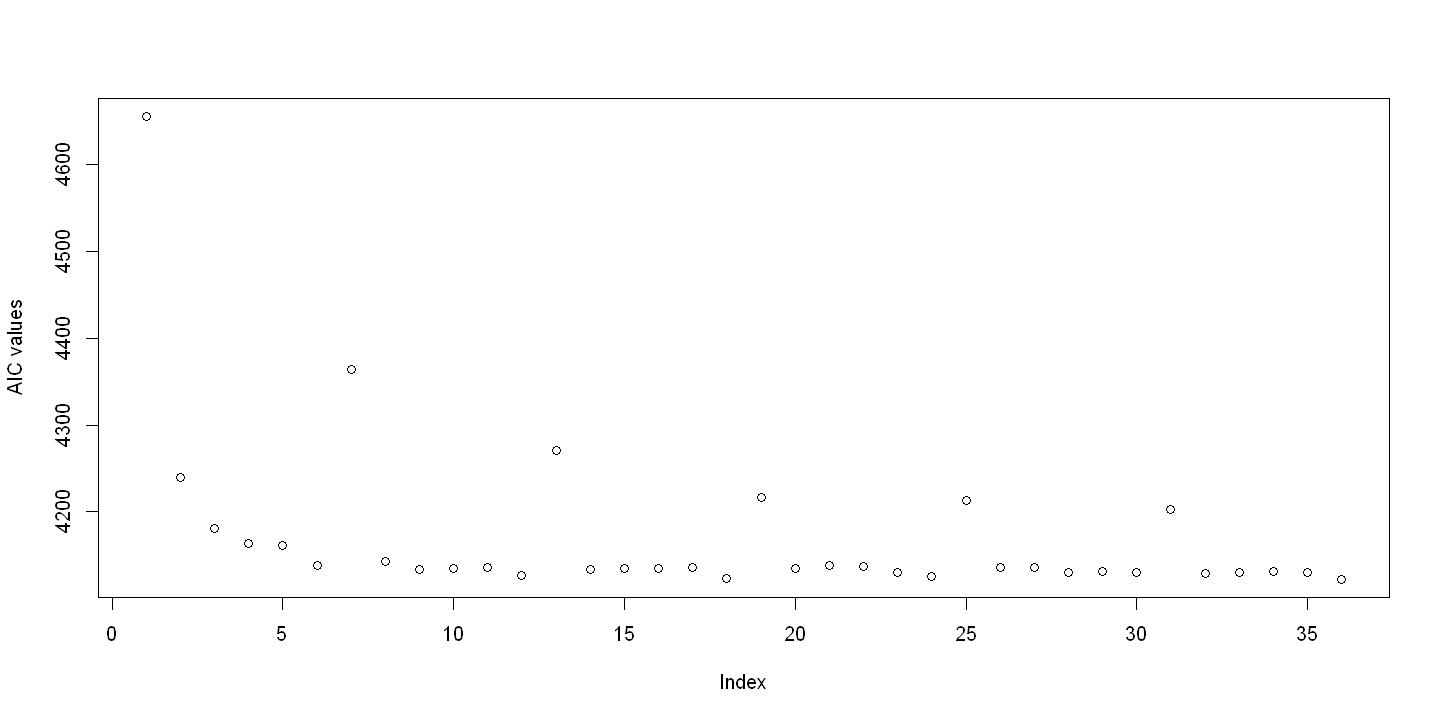

In [10]:
# Which order to select?

aicv = as.vector(aic)  
plot(aicv,ylab="AIC values")
indexp = rep(c(1:norder),norder)
indexq = rep(c(1:norder),each=norder)
indexaic = which(aicv == min(aicv))
porder = indexp[indexaic]-1
qorder = indexq[indexaic]-1
porder
qorder

final_model = arima(resid.process,order = c(porder,0,qorder), method='ML')

The R code provided here first labels each AIC value with its corresponding p and q orders, then the which() command finds the index in the vector of AIC values at the minimum, then extracts the p and q orders for this minimum. The selected orders are p equal to five, and q equal to five, the largest orders allowed. Last we fit the model for the selected orders called here the final model.

### ARMA Model: Residual Analysis

These are the residual plots for the ARMA(5,5) fitted. The residuals do not improve or change significantly from the smaller models AR(6) or ARMA(6,1). Less complex models, in other words, those with smaller AR and MA orders are preferred to avoid over-fitting, or to obtain better predictions

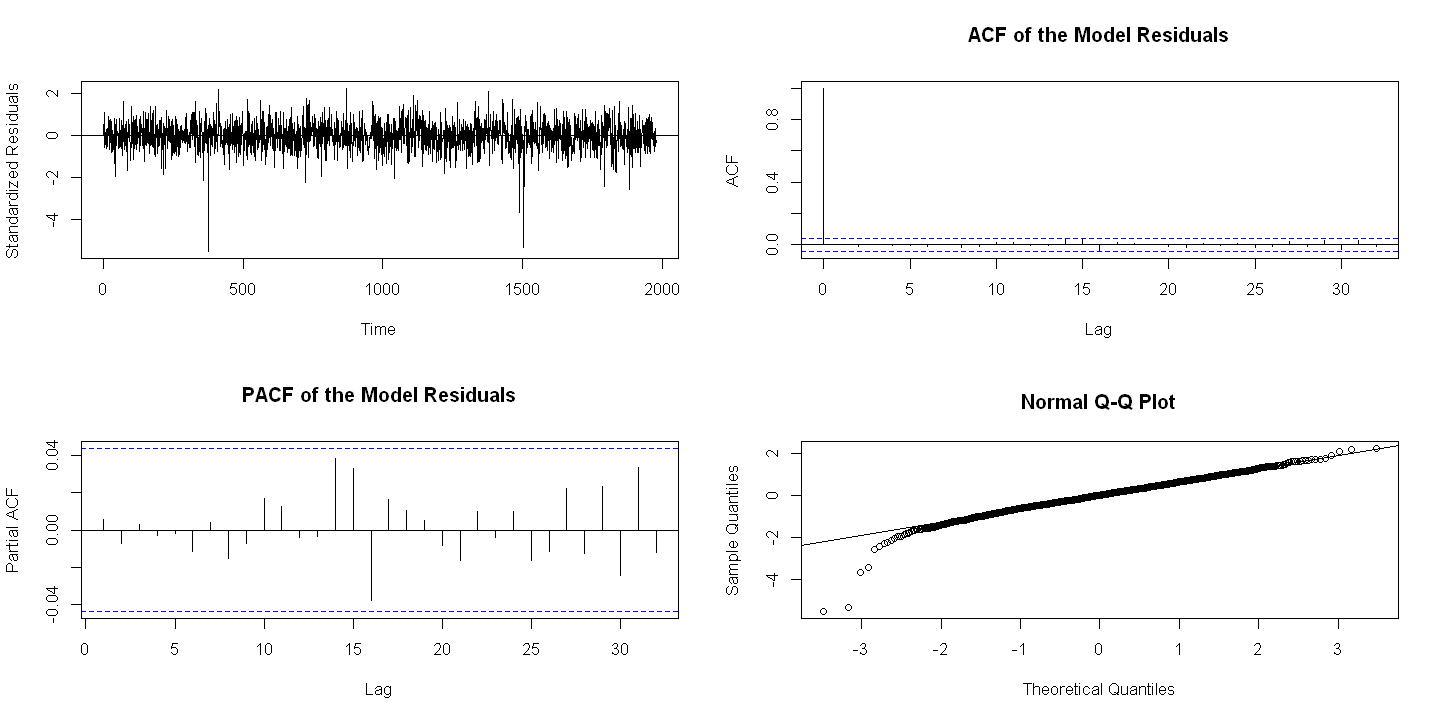

In [11]:
par (mfrow=c(2,2))
plot(resid(final_model), ylab='Standardized Residuals')
abline(h=0)
acf(as.vector(resid(final_model)),main= 'ACF of the Model Residuals')
pacf(as.vector(resid(final_model)),main='PACF of the Model Residuals')
qqnorm(resid(final_model))
qqline(resid(final_model))

### Testing for Uncorrelated Residuals

- The R command used for testing for uncorrelated residuals is the Box.test with the specification of the time series to be tested whether uncorrelated, and the maximum lag to be used for the test statistic, here the maximum lag is the sum of the two orders plus one. 
- We also can specify the type of the test. Here, I specified the Box-Pierce test in the first line and the Box-Ljung in the second line. 
- Last, we also need to input the degrees of freedom of the fit, which is the sum of the number of orders.
- I applied these tests for both the ARMA(5,5) final model, as well for the smaller ARMA(6,1) model. 

In [12]:
#### Test for Uncorrelated Residuals for the final model
Box.test(final_model$resid, lag = (porder+qorder+1), type = "Box-Pierce", fitdf = (porder+qorder))
Box.test(final_model$resid, lag = (porder+qorder+1), type = "Ljung-Box", fitdf = (porder+qorder))

#### Test Uncorrelated Residuals for the smaller model
Box.test(modarma$resid, lag = (porder+qorder+1), type = "Box-Pierce", fitdf = (porder+qorder))
Box.test(modarma$resid, lag = (porder+qorder+1), type = "Ljung-Box", fitdf = (porder+qorder))



	Box-Pierce test

data:  final_model$resid
X-squared = 1.9952, df = 1, p-value = 0.1578



	Box-Ljung test

data:  final_model$resid
X-squared = 2.0056, df = 1, p-value = 0.1567



	Box-Pierce test

data:  modarma$resid
X-squared = 2.2056, df = 1, p-value = 0.1375



	Box-Ljung test

data:  modarma$resid
X-squared = 2.2186, df = 1, p-value = 0.1364


This is the output for this implementation with a summary of each of the tests. 

**The P values are all large, indicating that a null hypothesis of uncorrelated residuals is plausible.** Thus, according to these tests, both models perform well in modeling the temporal correlation in the time series process since the residuals are uncorrelated.

## ARIMA Modeling

### Differencing Time Series

So far, we estimated the trend and seasonality of this time series and then subtracted the estimated trend and seasonality from the time series to obtain an approximately stationary process to be modeled with ARMA. In this lesson, we'll consider the differencing approach. 

First, let's consider the differenced time series to account for seasonality. Note that we've identified both monthly and day of the week seasonality. For the day-of-the-week seasonality, we can difference with frequency equal to seven, which will apply the difference from consecutive Mondays, Tuesdays, and so on.  Note that in order to apply the difference R command, I transformed the time series using the TS command with frequency equal to 365.25, indicating that this is daily data. 

I am illustrating here only the differenced time series for weekly stationarity since it is a regular differencing as the data are observed daily. We next compare the time series plots for the original time series versus the difference time series plot along with their ACF plots. These are the time series plots

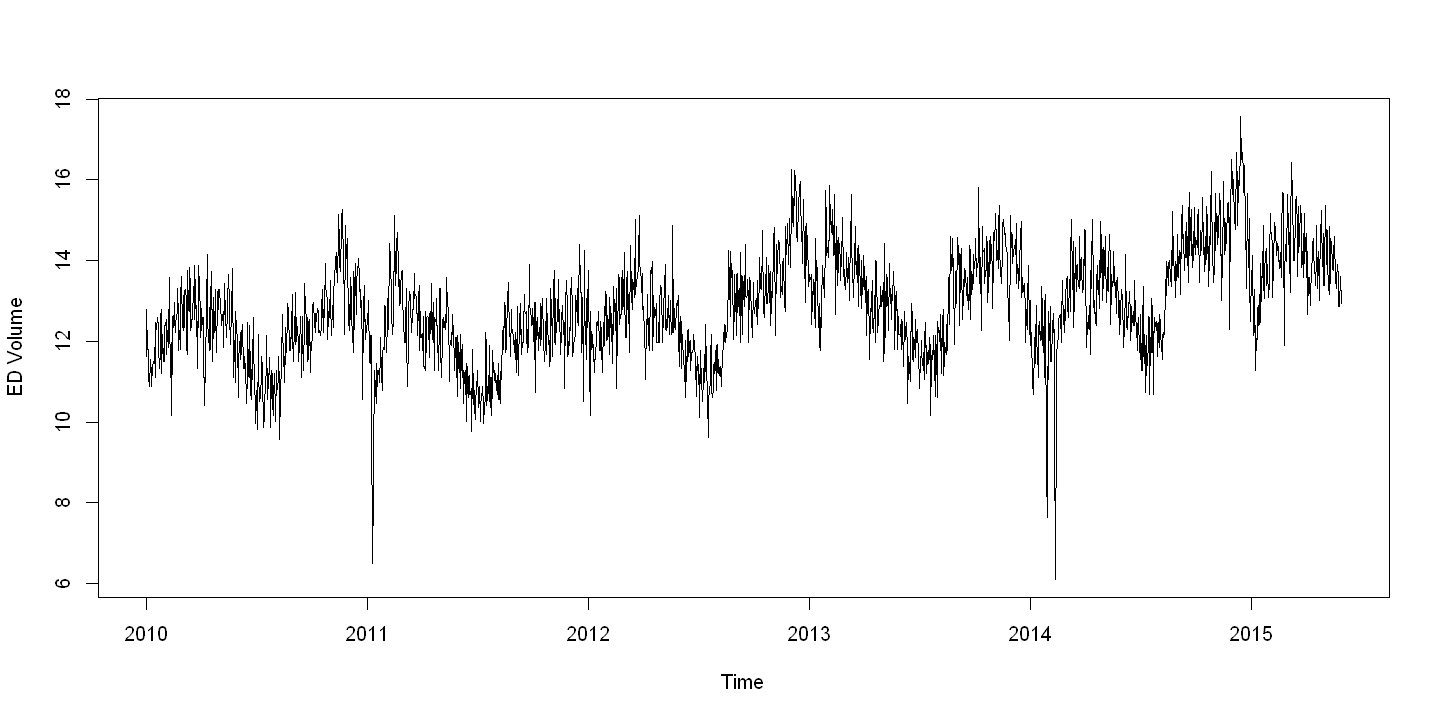

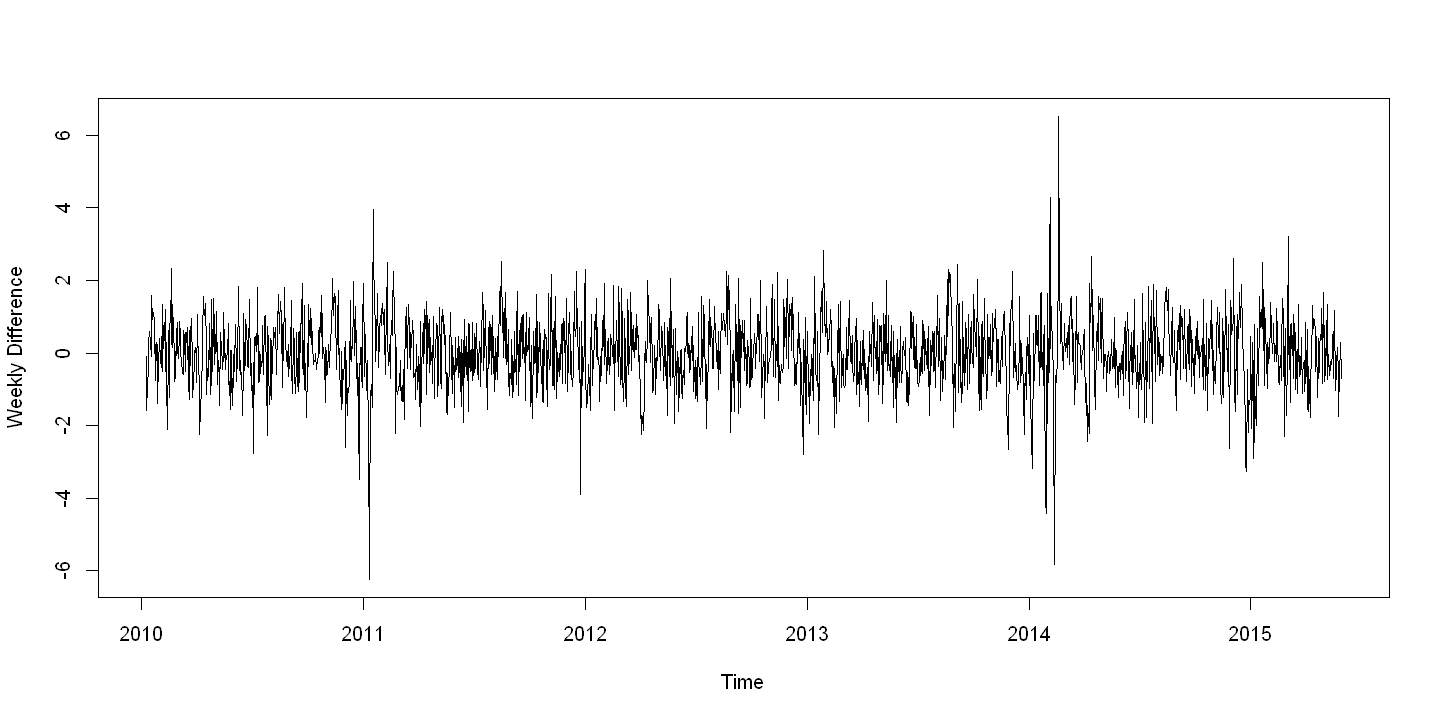

In [13]:
############################################################3
volume.ts = ts(Volume.tr,start=c(2010,1,1),frequency=365.25)
dvolume7=diff(volume.ts,7) # weekly

#plot time series and difference processes
par(mfrow=c(1,1))
ts.plot(volume.ts,ylab="ED Volume")
ts.plot(dvolume7,ylab="Weekly Difference")

The plot of the first time series is for the transform ED volume. The second is for day of the week differencing. While we see clear periodic patterns in the original time series, the pattern is not evident in the time series plot of the differencing process.

### Differencing Time Series: ACF & PACF

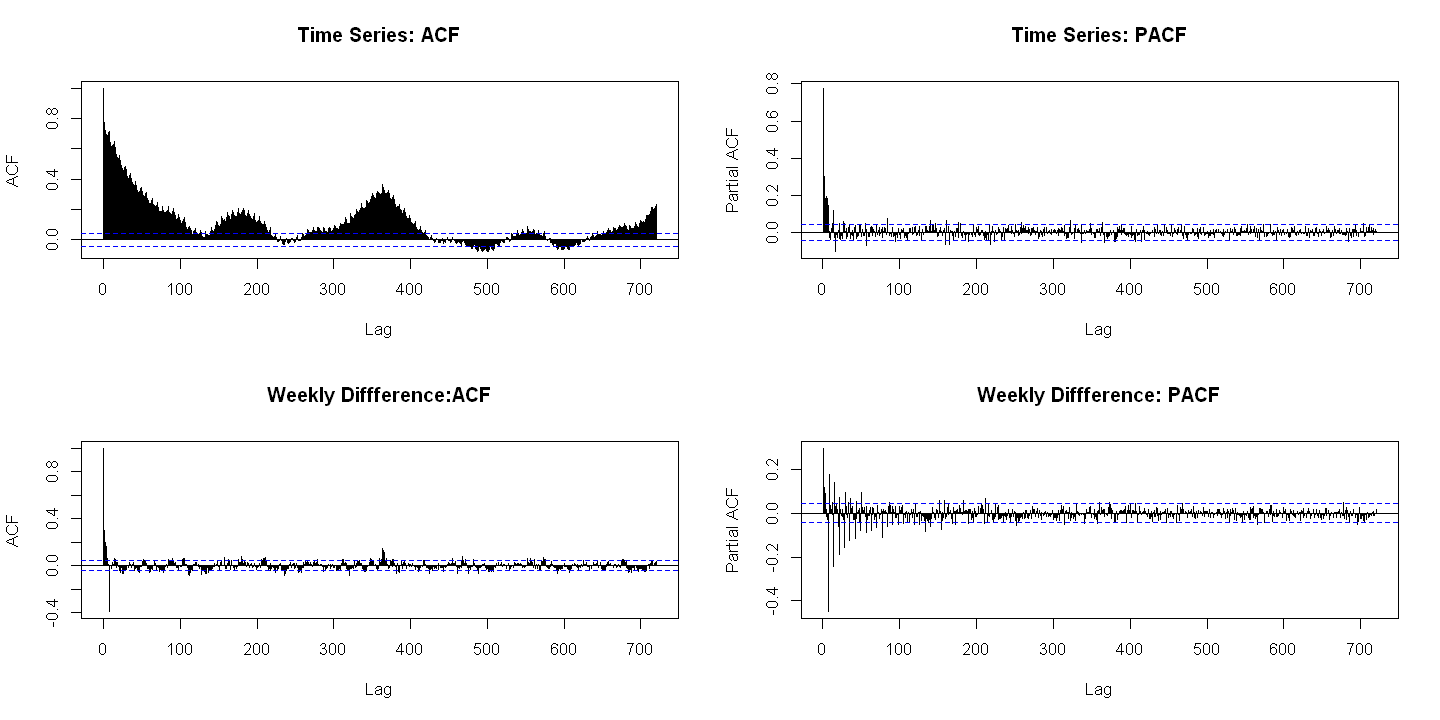

In [14]:
par(mfrow=c(2,2))
acf(as.vector(volume.ts), main='Time Series: ACF',lag.max=360*2)
acf(as.vector(volume.ts),type="partial", main='Time Series: PACF',lag.max=360*2)
acf(as.vector(dvolume7) , main='Weekly Diffference:ACF',lag.max=360*2)
acf(as.vector(dvolume7),type="partial", main='Weekly Diffference: PACF',lag.max=360*2)

These are the ACF and PACF plots for the two time series. The upper plots are the plots for the original time series, whereas, the bottom ones are the plots for the differencing process. The ACF plot of the original time series clearly shows a periodic pattern while the PACF does not. The ACF plot for the weekly differencing shows an improvement in terms of removing the seasonality. The PACF plot looks similar to that for the original time series

### Seasonal ARIMA Model Fit

Next, I am fitting a seasonal ARIMA. 

- Because we have both trend and seasonality, we need to fit an ARIMA to account for the trend and the seasonal ARMA to account for seasonality jointly. 
- The R command is the same as for ARMA fit, specifically, the arima() command, except that now, we are fitting multiple orders both for the ARMA and for the seasonal ARMA. 
- The input orders for the ARMA model are p=5, d=1, and q=5, meaning that we have an AR order of 5, a differencing order equal to 1, and MA order equal to 5. 
- We also use a seasonal order of (1,0,1) which means that we're fitting a seasonal ARMA with AR order equal to 1, and MA order equal to 1. 

Note that one limitation of the seasonal ARMA is that it only can model one type of seasonality. In this data example, we established both weekly and monthly seasonality and thus, it would be more appropriate to fit both types of seasonality

Warning message in arima(volume.ts, order = c(5, 1, 5), seasonal = list(order = c(1, :
"possible convergence problem: optim gave code = 1"


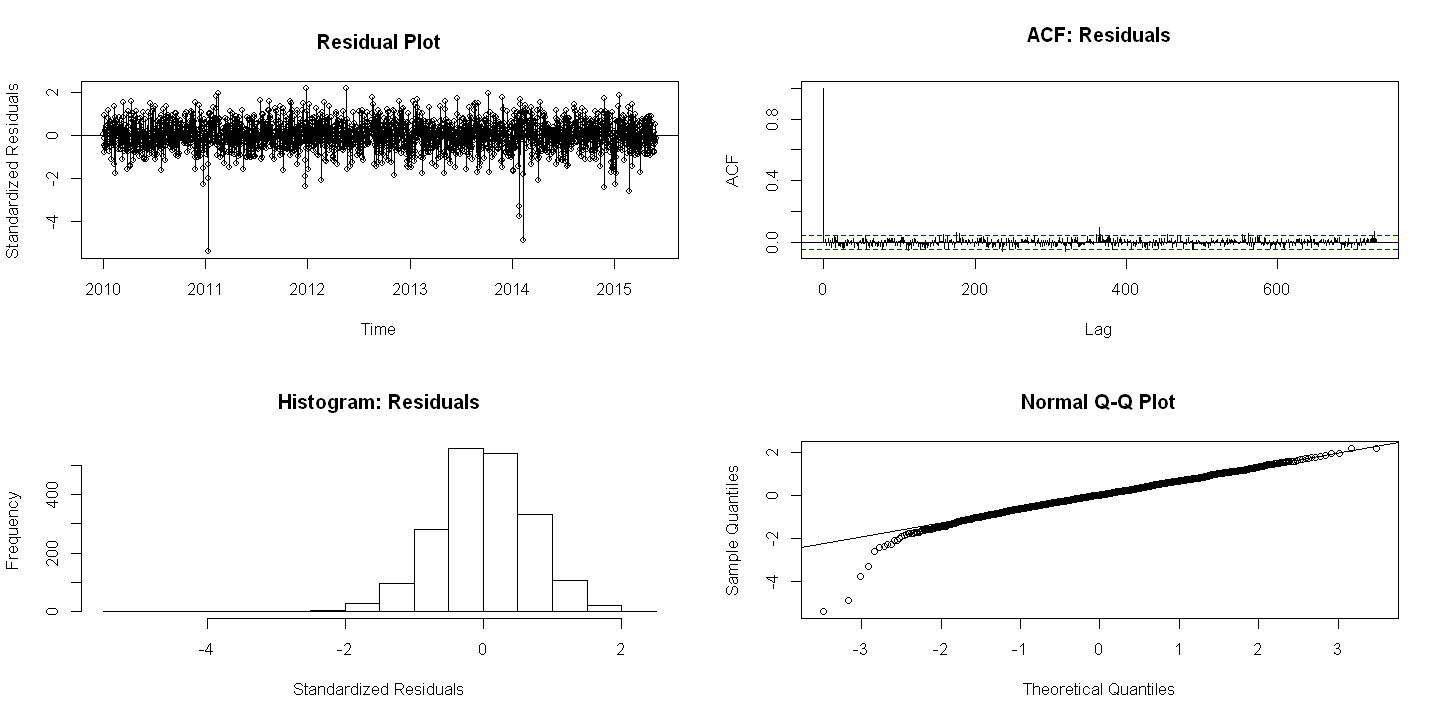

In [15]:
## Model Fitting ARIMA(5,1,5)+seasonal ARMA(1,1)
mod = arima(volume.ts, order = c(5,1,5),seasonal = list(order = c(1,0,1),period=7),method = "ML")

par(mfrow=c(2,2))

# residual analysis
plot(resid(mod), ylab='Standardized Residuals',type='o',main="Residual Plot")
abline(h=0)
acf(as.vector(resid(mod)),lag.max=365*2,main="ACF: Residuals")
hist(resid(mod),xlab='Standardized Residuals',main='Histogram: Residuals')
qqnorm(resid(mod))
qqline(resid(mod))

These are the residual plots. 
- The first one displays standardized residuals vs time. From this plot, we identify a relatively constant variance over time.
- The upper plot on the right is the ACF plot of the residuals. Note that for this, I specify a **large lag to identify any other potential seasonality.** 
- **The residuals are all small, most of them within the confidence band, an indication that the residuals may be white noise, indicating that modeling the weekly seasonality may be sufficient.**
- The bottom plots investigate the assumption of normality, which is assumed for the maximum likelihood fit. The residuals do show skewness although it is not very severe.

### Forecasting with ARIMA

Last, let's see how we can forecast with ARIMA. 
- For this forecasting exercise, I left out two weeks of the data, the last two weeks in the time series. 
- Then I fitted the same ARIMA model as provided in the previous slide, but this time, to the time series without the last two weeks of data. 
- Last, I applied the prediction command in R that allows us to predict given the fitted model as input and given the number of lags ahead to obtain the prediction, in this case, two weeks.

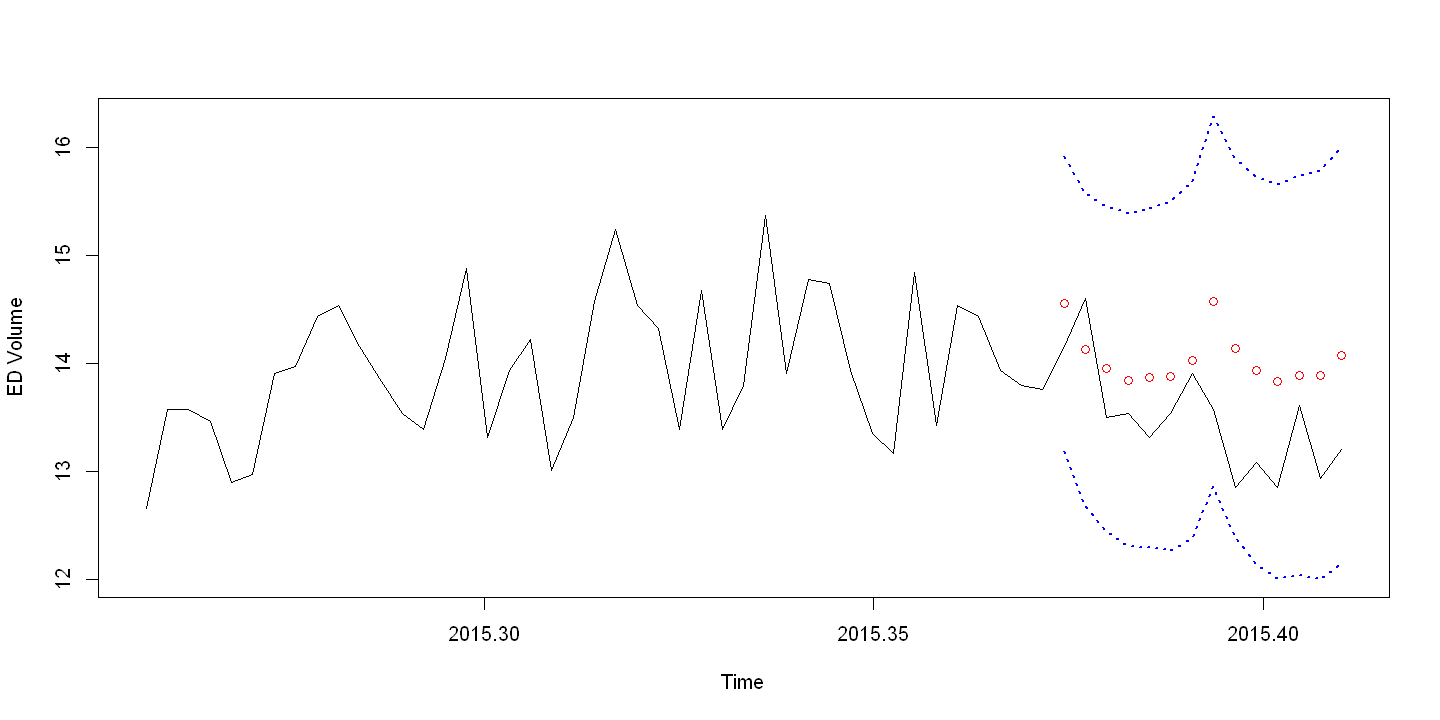

In [16]:
## Forecasting with ARIMA: 2 Weeks Ahead
n = length(volume.ts)
nfit = n-14
outvol = arima(volume.ts[1:nfit], order = c(5,1,5),seasonal = list(order = c(1,0,1),period=7),method = "ML")
out_pred = as.vector(predict(outvol,n.ahead=14))

timevol=time(volume.ts)
ubound = out_pred$pred+1.96*out_pred$se
lbound = out_pred$pred-1.96*out_pred$se
ymin = min(lbound)
ymax = max(ubound)
par(mfrow=c(1,1))
plot(timevol[(n-56):n],volume.ts[(n-56):n],type="l", ylim=c(ymin,ymax), xlab="Time", ylab="ED Volume")
points(timevol[(nfit+1):n],out_pred$pred,col="red")
lines(timevol[(nfit+1):n],ubound,lty=3,lwd= 2, col="blue")
lines(timevol[(nfit+1):n],lbound,lty=3,lwd= 2, col="blue")

We next compare the predictions for the two weeks with the observed time series. 

- We first form the confidence band of the prediction with the upper band provided by ubound and the lower band provided by lbound. 
- Then we plot the time series data. We do not plot the entire history of the time series but only the last four weeks of data. - We overlay the predicted values in red along with the confidence band in blue.

The corresponding plot is here. 

- The black line is the observed time series, the red points are the predicted values, along with the confidence band in blue.
- All the observed values are within the confidence band. 
- The predicted values are somewhere close to the observed values, except that they do not capture the volatility in the observed time series.

### End